### Импорт библиотек

In [1]:
import tensorflow as tf

In [2]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(52)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, GRU, SimpleRNN
import keras
%matplotlib inline

### Загрузка данных

In [4]:
# read training data 
train_df = pd.read_csv('./PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [5]:
# read test data
test_df = pd.read_csv('./PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [6]:
# read ground truth data
truth_df = pd.read_csv('./PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [7]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [8]:
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [9]:
test_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [10]:
truth_df

,0
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


## Обработка данных

In [11]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [12]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [13]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [14]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [15]:
truth_df.columns

Index([0], dtype='int64')

In [16]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [17]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [18]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


## Моделирование


In [19]:
# pick a large window size of 50 cycles
sequence_length = 50

In [20]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id
engine_id3 = test_df[test_df['id'] == 11]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

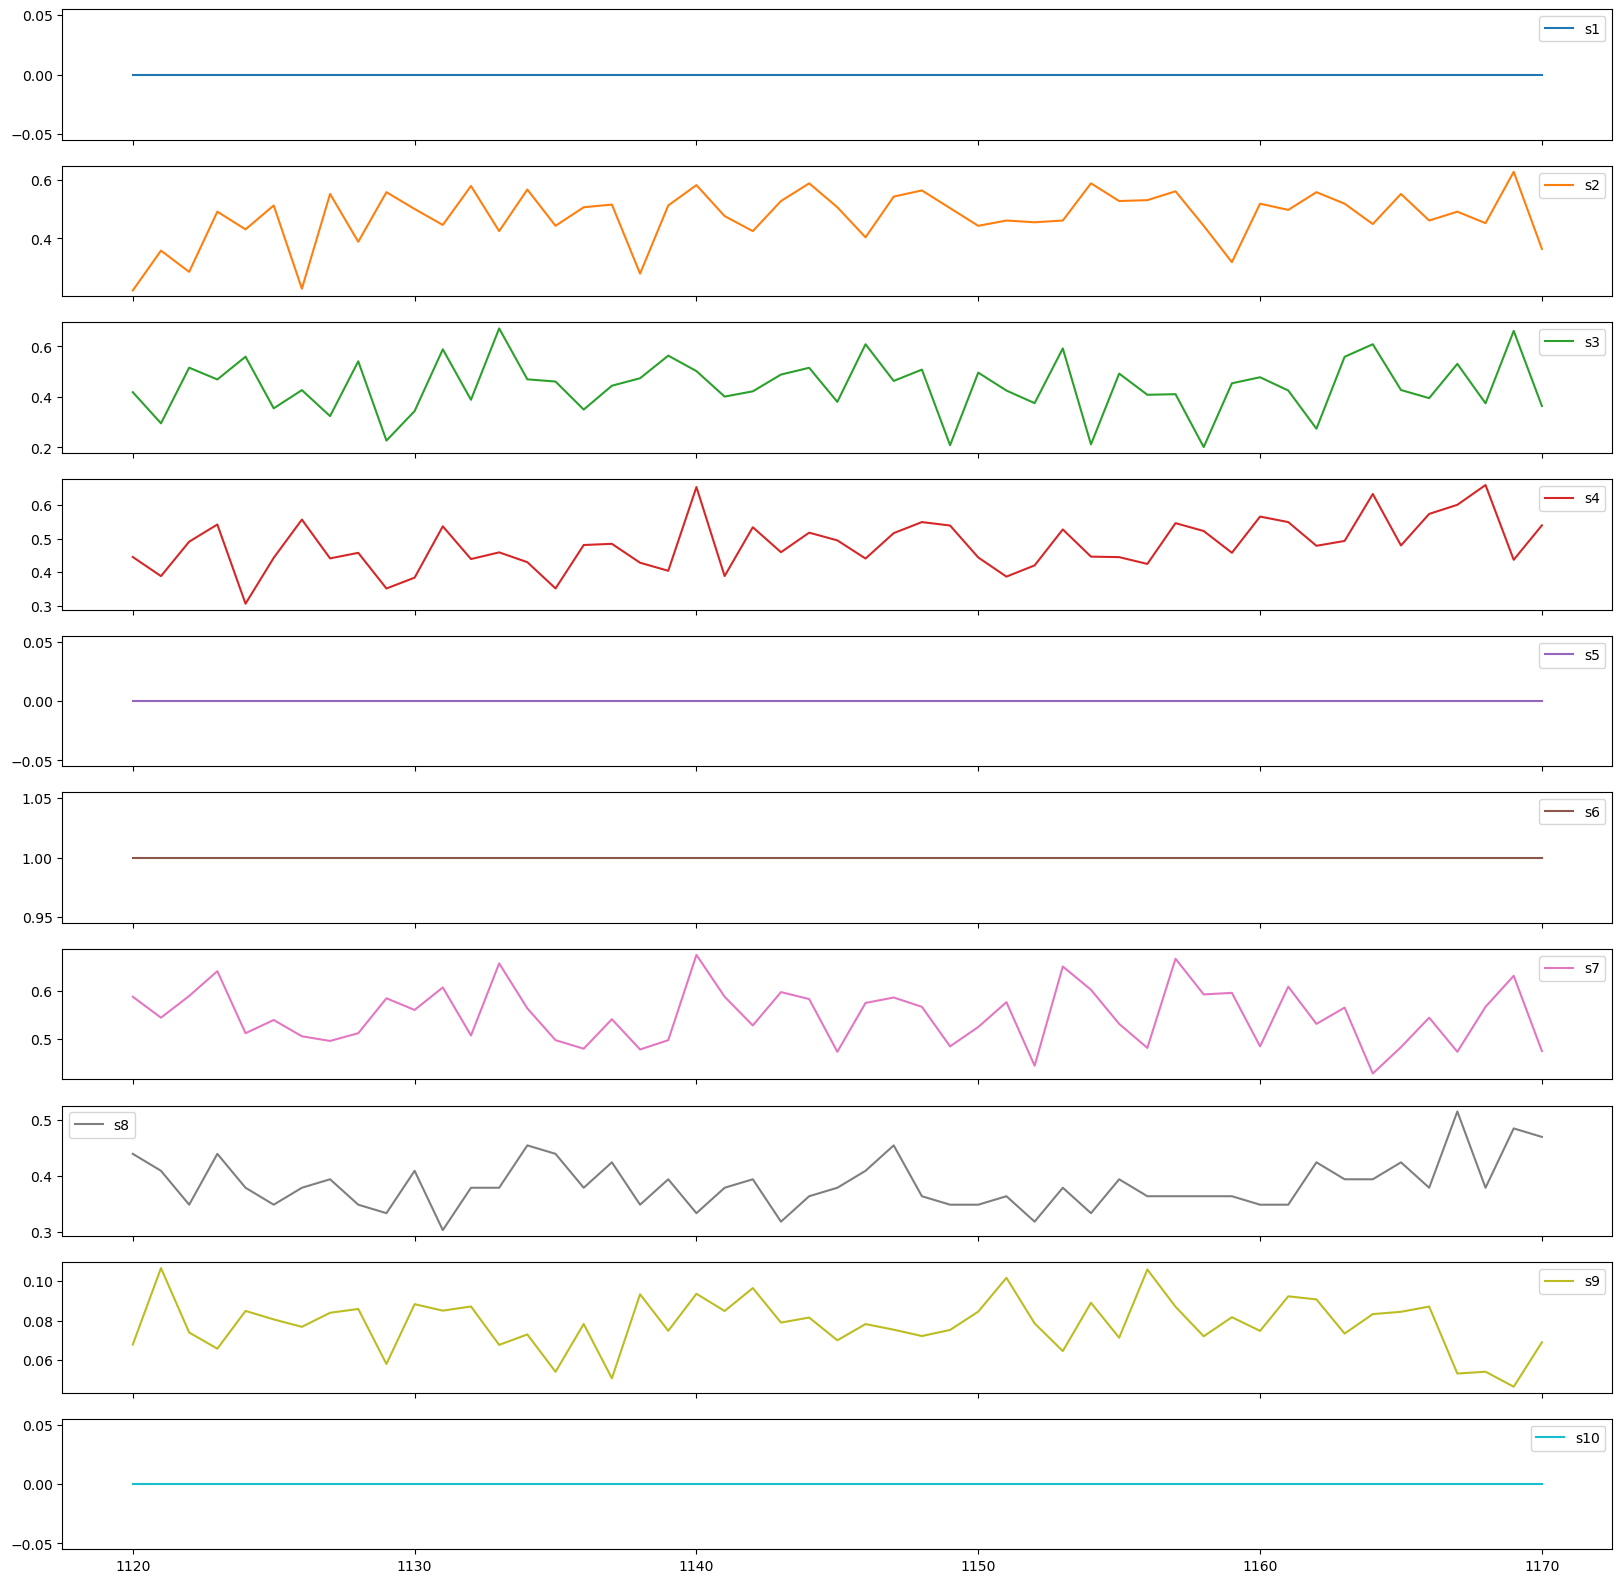

In [21]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

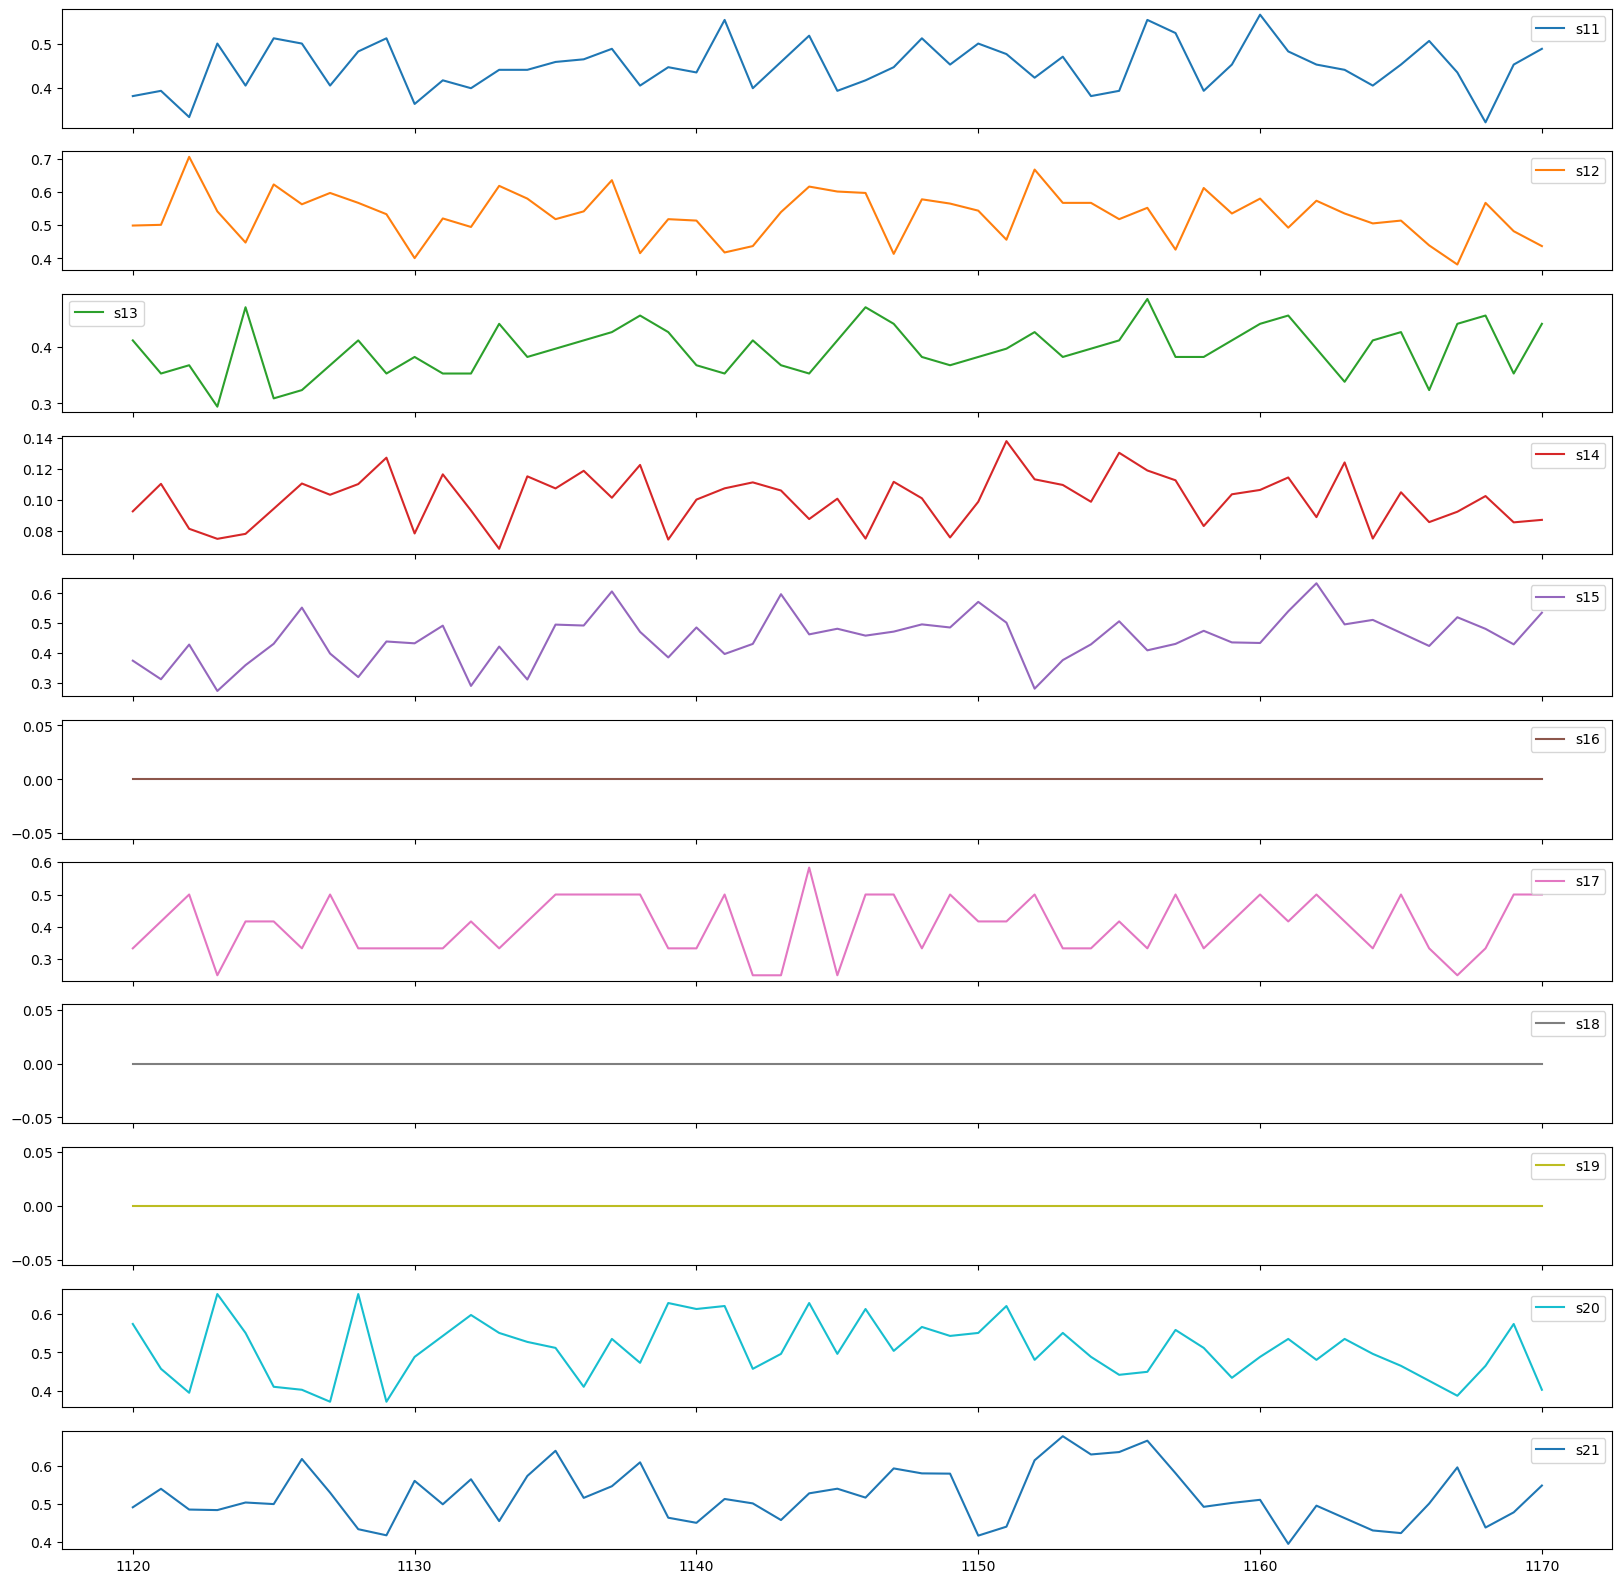

In [22]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

In [23]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [24]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [25]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [26]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [27]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [28]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

## LSTM

In [29]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


### CPU

Epoch 1/100
75/75 [==============================] - 8s 85ms/step - loss: 0.2322 - accuracy: 0.9009 - val_loss: 0.0582 - val_accuracy: 0.9757
Epoch 2/100
75/75 [==============================] - 6s 79ms/step - loss: 0.0967 - accuracy: 0.9603 - val_loss: 0.1097 - val_accuracy: 0.9552


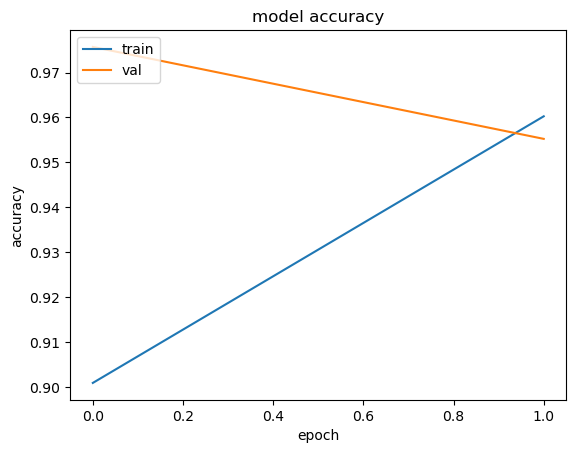

CPU times: total: 1min 8s
Wall time: 13.8 s


In [31]:
%%time
# fit the network
with tf.device('/CPU:0'):
    history_lstm = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=1,
            callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
    plt.plot(history_lstm.history['accuracy'])
    plt.plot(history_lstm.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### GPU

In [32]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/100
75/75 [==============================] - 4s 16ms/step - loss: 0.2567 - accuracy: 0.8876 - val_loss: 0.0931 - val_accuracy: 0.9719
Epoch 2/100
75/75 [==============================] - 1s 10ms/step - loss: 0.0921 - accuracy: 0.9618 - val_loss: 0.0408 - val_accuracy: 0.9936


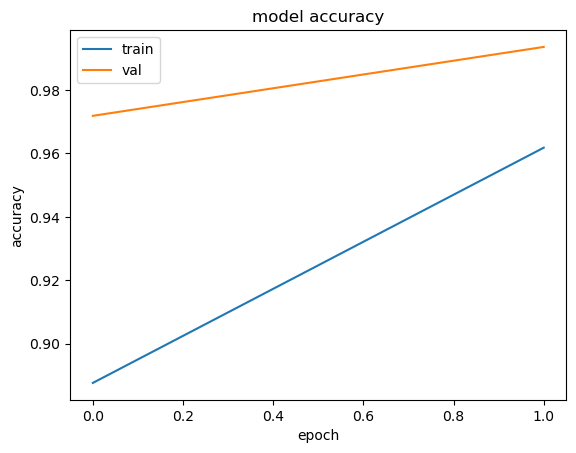

CPU times: total: 4.92 s
Wall time: 4.94 s


In [33]:
%%time
# fit the network
history_lstm = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 1s 6ms/step - loss: 0.0700 - accuracy: 0.9722
Accurracy: 0.9722346663475037


In [35]:
# make predictions and compute confusion matrix
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_pred = np.argmax(y_pred,axis=1)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

79/79 [==============================] - 1s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12531,     0],
       [ 3100,     0]], dtype=int64)

In [36]:
print(classification_report(y_true, y_pred, zero_division=0))

precision_test = precision_score(y_true, y_pred)
recall_test = recall_score(y_true, y_pred)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n' )

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89     12531
         1.0       0.00      0.00      0.00      3100

    accuracy                           0.80     15631
   macro avg       0.40      0.50      0.44     15631
weighted avg       0.64      0.80      0.71     15631

Precision:  0.0 
 Recall:  0.0 



c:\Users\Felix-PC\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [39]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

Similarly, we pick the labels.

In [40]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [41]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [42]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0810 - accuracy: 0.9570 - 61ms/epoch - 20ms/step
Accurracy: 0.9569892287254333


In [43]:
# make predictions and compute confusion matrix
y_pred_test = model.predict(seq_array_test_last)
y_pred_test = np.argmax(y_pred_test,axis=1)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

3/3 [==============================] - 0s 24ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[68,  0],
       [25,  0]], dtype=int64)

In [44]:
print(classification_report(y_true_test, y_true_test))

# compute precision and recall
precision_test = precision_score(y_true_test, y_true_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        68
         1.0       1.00      1.00      1.00        25

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93

Precision:  1.0 
 Recall:  0.0 
 F1-score: 0.0


In [45]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test],
                          [0.94, 0.952381, 0.8, 0.869565]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM',
                                 'Template Best Model'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.956989,1.000000,0.0,0.000000
Template Best Model,0.940000,0.952381,0.8,0.869565


## GRU

In [47]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model_gru = Sequential()

model_gru.add(GRU(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(
          units=50,
          return_sequences=False))
model_gru.add(Dropout(0.2))

model_gru.add(Dense(units=nb_out, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
print(model_gru.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 100)           38100     
                                                                 
 dropout_4 (Dropout)         (None, 50, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 50)                22800     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 60,951
Trainable params: 60,951
Non-trainable params: 0
_________________________________________________________________
None


### CPU

Epoch 1/100
75/75 [==============================] - 7s 77ms/step - loss: 0.2446 - accuracy: 0.8999 - val_loss: 0.1608 - val_accuracy: 0.9297
Epoch 2/100
75/75 [==============================] - 5s 68ms/step - loss: 0.1278 - accuracy: 0.9471 - val_loss: 0.0852 - val_accuracy: 0.9680


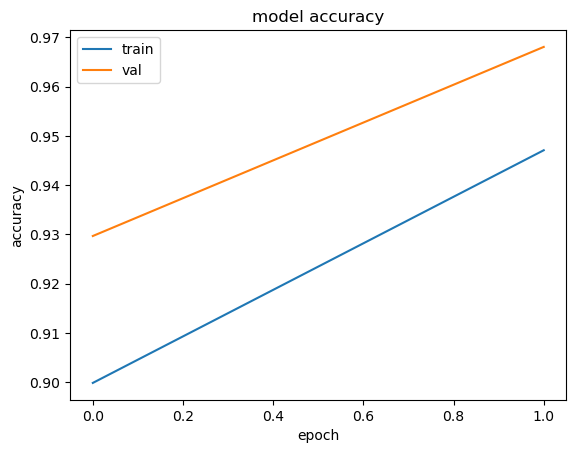

CPU times: total: 1min 1s
Wall time: 12.5 s


In [49]:
%%time
# fit the network
with tf.device('/CPU:0'):
    history_gru = model_gru.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=1,
            callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
    plt.plot(history_gru.history['accuracy'])
    plt.plot(history_gru.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [50]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model_gru = Sequential()

model_gru.add(GRU(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(
          units=50,
          return_sequences=False))
model_gru.add(Dropout(0.2))

model_gru.add(Dense(units=nb_out, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/100
75/75 [==============================] - 2s 16ms/step - loss: 0.2300 - accuracy: 0.9024 - val_loss: 0.1681 - val_accuracy: 0.9309
Epoch 2/100
75/75 [==============================] - 1s 10ms/step - loss: 0.1231 - accuracy: 0.9475 - val_loss: 0.1409 - val_accuracy: 0.9476


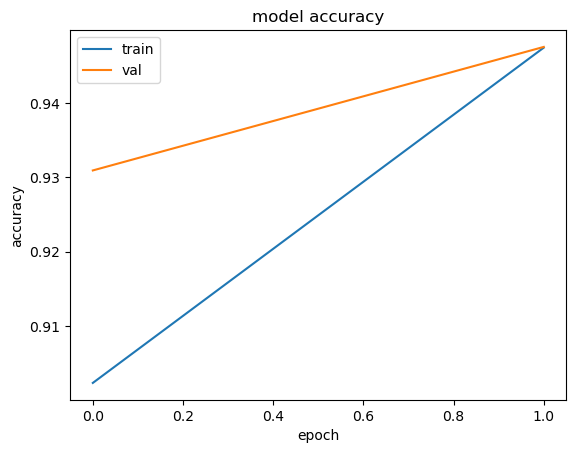

CPU times: total: 3.47 s
Wall time: 3.36 s


In [51]:
%%time
# fit the network
history_gru = model_gru.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
# training metrics
scores = model_gru.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))
# make predictions and compute confusion matrix
y_pred = model_gru.predict(seq_array,verbose=1, batch_size=200)
y_pred = np.argmax(y_pred,axis=1)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred, zero_division=0))

print("test data")
y_pred_test = model_gru.predict(seq_array_test_last)
y_pred_test = np.argmax(y_pred_test,axis=1)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

print(classification_report(y_true_test, y_pred_test, zero_division=0))

precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

79/79 [==============================] - 0s 5ms/step - loss: 0.1071 - accuracy: 0.9604
Accurracy: 0.9603992104530334
79/79 [==============================] - 1s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12531     0]
 [ 3100     0]]
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89     12531
         1.0       0.00      0.00      0.00      3100

    accuracy                           0.80     15631
   macro avg       0.40      0.50      0.44     15631
weighted avg       0.64      0.80      0.71     15631

test data
3/3 [==============================] - 0s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[68  0]
 [25  0]]
              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84        68
         1.0       0.00      0.00      0.00        25

    accuracy                           0.73        93
   macro avg       0.37      0.5

c:\Users\Felix-PC\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Felix-PC\AppData\Local\Temp\ipykernel_21464\486330730.py:25: RuntimeWarning: invalid value encountered in scalar divide
  f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)


In [53]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test],
                          [0.94, 0.952381, 0.8, 0.869565]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['GRU',
                                 'Template Best Model'])
results_df

,Accuracy,Precision,Recall,F1-score
GRU,0.956989,0.000000,0.0,NaN
Template Best Model,0.940000,0.952381,0.8,0.869565


## RNN

In [54]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model_rnn = Sequential()

model_rnn.add(SimpleRNN(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model_rnn.add(Dropout(0.2))

model_rnn.add(SimpleRNN(
          units=50,
          return_sequences=False))
model_rnn.add(Dropout(0.2))

model_rnn.add(Dense(units=nb_out, activation='sigmoid'))
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
print(model_rnn.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 100)           12600     
                                                                 
 dropout_8 (Dropout)         (None, 50, 100)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
_________________________________________________________________
None


### CPU

Epoch 1/100
75/75 [==============================] - 4s 45ms/step - loss: 0.1990 - accuracy: 0.9153 - val_loss: 0.1400 - val_accuracy: 0.9361
Epoch 2/100
75/75 [==============================] - 3s 41ms/step - loss: 0.1153 - accuracy: 0.9522 - val_loss: 0.1024 - val_accuracy: 0.9501


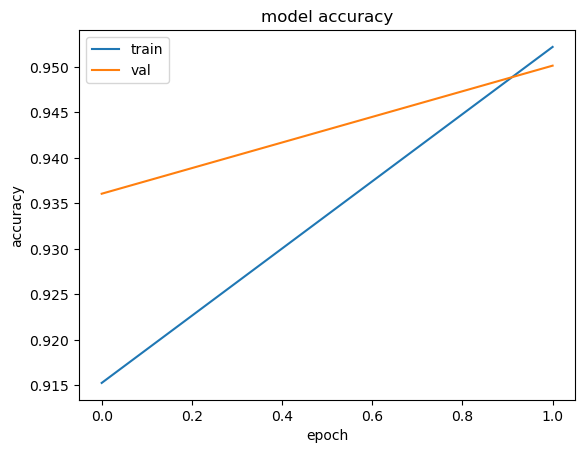

CPU times: total: 36 s
Wall time: 7.24 s


In [56]:
%%time
# fit the network
with tf.device('/CPU:0'):
    history_rnn = model_rnn.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=1,
            callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
    plt.plot(history_rnn.history['accuracy'])
    plt.plot(history_rnn.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### GPU

In [57]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model_rnn = Sequential()

model_rnn.add(SimpleRNN(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model_rnn.add(Dropout(0.2))

model_rnn.add(SimpleRNN(
          units=50,
          return_sequences=False))
model_rnn.add(Dropout(0.2))

model_rnn.add(Dense(units=nb_out, activation='sigmoid'))
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/100
75/75 [==============================] - 5s 57ms/step - loss: 0.2230 - accuracy: 0.9015 - val_loss: 0.1454 - val_accuracy: 0.9297
Epoch 2/100
75/75 [==============================] - 4s 55ms/step - loss: 0.1401 - accuracy: 0.9422 - val_loss: 0.1556 - val_accuracy: 0.9386


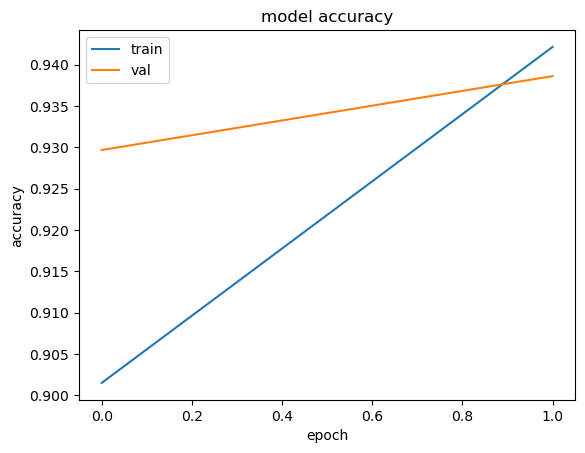

CPU times: total: 13.4 s
Wall time: 9.2 s


In [58]:
%%time
# fit the network
history_rnn = model_rnn.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
# training metrics
scores = model_rnn.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))
# make predictions and compute confusion matrix
y_pred = model_rnn.predict(seq_array,verbose=1, batch_size=200)
y_pred = np.argmax(y_pred,axis=1)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred, zero_division=0))

print("test data")
y_pred_test = model_rnn.predict(seq_array_test_last)
y_pred_test = np.argmax(y_pred_test,axis=1)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

print(classification_report(y_true_test, y_pred_test, zero_division=0))

precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

79/79 [==============================] - 1s 9ms/step - loss: 0.1237 - accuracy: 0.9491
Accurracy: 0.9490755796432495
79/79 [==============================] - 1s 7ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12531     0]
 [ 3100     0]]
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89     12531
         1.0       0.00      0.00      0.00      3100

    accuracy                           0.80     15631
   macro avg       0.40      0.50      0.44     15631
weighted avg       0.64      0.80      0.71     15631

test data
3/3 [==============================] - 0s 9ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[68  0]
 [25  0]]
              precision    recall  f1-score   support

         0.0       0.73      1.00      0.84        68
         1.0       0.00      0.00      0.00        25

    accuracy                           0.73        93
   macro avg       0.37      0.5

c:\Users\Felix-PC\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Felix-PC\AppData\Local\Temp\ipykernel_21464\2887861841.py:25: RuntimeWarning: invalid value encountered in scalar divide
  f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)


In [60]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test],
                          [0.94, 0.952381, 0.8, 0.869565]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['RNN',
                                 'Template Best Model'])
results_df

,Accuracy,Precision,Recall,F1-score
RNN,0.956989,0.000000,0.0,NaN
Template Best Model,0.940000,0.952381,0.8,0.869565
